# Data download

In [ ]:
%%writefile kaggle.json
{"username":"rushikeshdarge","key":"********************************"}

Writing kaggle.json


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d vaibhavkumar11/hindi-english-parallel-corpus
!unzip /content/hindi-english-parallel-corpus.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 94% 105M/112M [00:01<00:00, 66.5MB/s] 
100% 112M/112M [00:01<00:00, 66.0MB/s]
Archive:  /content/hindi-english-parallel-corpus.zip
  inflating: hindi_english_parallel.csv  


In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

* Download model to check the language from fasttext

In [ ]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 5.6 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3138162 sha256=a68b0bb55a2c33cc1e37e2a850c03411c334d62fdf1c874fa4a611f9e33fafe0
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
# https://fasttext.cc/docs/en/language-identification.html
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz

--2022-07-09 05:28:53--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 938013 (916K) [binary/octet-stream]
Saving to: ‘lid.176.ftz’

lid.176.ftz         100%[===================>] 916.03K  1.19MB/s    in 0.8s    

2022-07-09 05:28:55 (1.19 MB/s) - ‘lid.176.ftz’ saved [938013/938013]



In [ ]:
import fasttext
model = fasttext.load_model('/content/lid.176.ftz')
print(model.predict('निचले पटल के लिए डिफोल्ट प्लग-इन खाका', k=1))  # top 2 matching languages

(('__label__hi',), array([0.95343572]))


## Load dataset

In [ ]:
df = pd.read_csv('/content/hindi_english_parallel.csv', nrows=50000)
df.head()

,hindi,english
0,अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें,Give your application an accessibility workout
1,एक्सेर्साइसर पहुंचनीयता अन्वेषक,Accerciser Accessibility Explorer
2,निचले पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the bottom panel
3,ऊपरी पटल के लिए डिफोल्ट प्लग-इन खाका,The default plugin layout for the top panel
4,उन प्लग-इनों की सूची जिन्हें डिफोल्ट रूप से नि...,A list of plugins that are disabled by default


In [ ]:
df.isnull().sum()

hindi      3
english    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(49997, 2)

In [ ]:
df.sample(4)

,hindi,english
10809,बिल्ड आटोटूल,Build Autotools
38816,चयनित मौन हटाएँ,Remove the selected slices
48845,खराब घटना,Bad event
39287,कुंजीपटल,Keyboard


In [ ]:
import string
from string import digits

## Cleaning dataset

In [ ]:
# Lowercase all characters
df['english']=df['english'].apply(lambda x: x.lower())
# Remove quotes
df['english']=df['english'].apply(lambda x: re.sub("'", '', x))
df['hindi']=df['hindi'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df['english']=df['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi']=df['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['english']=df['english'].apply(lambda x: x.translate(remove_digits))
df['hindi']=df['hindi'].apply(lambda x: x.translate(remove_digits))

df['hindi'] = df['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))
# if english text in hindi column
df['hindi'] = df['hindi'].apply(lambda x: re.sub("[A-Za-z]", "", x))

# remove extra
df['english']=df['english'].apply(lambda x: re.sub('[-_.:;\[\]\|,]', '', x))
df['hindi']=df['hindi'].apply(lambda x: re.sub('[-_.;\[\]\|,]', '', x))

# Remove extra spaces
df['english']=df['english'].apply(lambda x: x.strip())
df['hindi']=df['hindi'].apply(lambda x: x.strip())
df['english']=df['english'].apply(lambda x: re.sub(" +", " ", x))
df['hindi']=df['hindi'].apply(lambda x: re.sub(" +", " ", x))

In [ ]:
df.sample(5)

,hindi,english
49092,अधिकतम वीडियो बिटरेट में वीडियो गुणवत्ता और प्...,the maximum video bitrate in kbits s the video...
33155,फ़ाइल पूर्वावलोकन सक्रिय करें,enable file preview
41435,सामग्री को दोहराने के बजाय उन्हें क्षैतिज स्के...,repeat the contents rather than scaling them h...
46386,दो बटन गतिशील मोड,two button dynamic mode
19448,कमिट कोः,commit to cherry pick


In [ ]:
df['is_hindi'] = True
df['is_english'] = True

## Check language of text

In [ ]:
error = []
count = 0
for i,row in tqdm(df.iterrows()):
    hi_tex = df.iloc[i]['hindi']
    en_tex = df.iloc[i]['english']
    try:
        hin_pred = model.predict(hi_tex,k=3)[0]
        if set(['__label__hi']).issubset(hin_pred) or set(['__label__mr']).issubset(hin_pred):
            pass
        else:
            df.at[i,'is_hindi'] = False
            count += 1
        en_pred = model.predict(en_tex,k=3)[0]
        if set(['__label__en']).issubset(en_pred):
            pass
        else:
            df.at[i,'is_english'] = False
            count += 1
    except:
        error.append(i)

In [ ]:
df[df.is_english == False].shape

(2454, 4)

In [ ]:
df[df.is_hindi == False].shape

(2780, 4)

In [ ]:
df.shape

(49997, 4)

In [ ]:
df = df[~df.is_hindi == False]
df = df[~df.is_english == False]
df.shape

(45032, 4)

In [ ]:
df.drop(columns=['is_hindi','is_english'],inplace=True)

## Len of sentence

In [ ]:
df['hindi_len'] = df['hindi'].apply(lambda x: len(x.split()))
df['english_len'] = df['english'].apply(lambda x: len(x.split()))

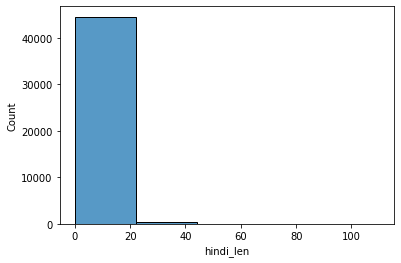

In [ ]:
sns.histplot(df.hindi_len, bins=5)

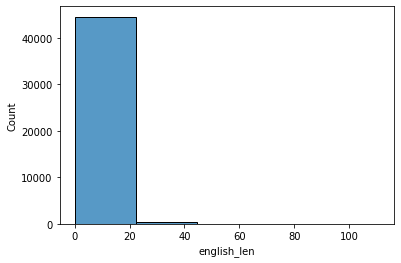

In [ ]:
sns.histplot(df.english_len, bins=5)

In [ ]:
# english
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.english_len, i)))

10 Quantile is 1.0
20 Quantile is 2.0
30 Quantile is 2.0
40 Quantile is 2.0
50 Quantile is 3.0
60 Quantile is 4.0
70 Quantile is 5.0
80 Quantile is 6.0
90 Quantile is 9.0
100 Quantile is 111.0


In [ ]:
# english
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.english_len, i)))

90 Quantile is 9.0
91 Quantile is 9.0
92 Quantile is 10.0
93 Quantile is 10.0
94 Quantile is 11.0
95 Quantile is 11.0
96 Quantile is 12.0
97 Quantile is 14.0
98 Quantile is 17.0
99 Quantile is 24.0
100 Quantile is 111.0


In [ ]:
# hindi
for i in np.arange(0.1,1.1,0.1):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.hindi_len, i)))

10 Quantile is 1.0
20 Quantile is 1.0
30 Quantile is 2.0
40 Quantile is 2.0
50 Quantile is 3.0
60 Quantile is 3.0
70 Quantile is 4.0
80 Quantile is 6.0
90 Quantile is 8.0
100 Quantile is 110.0


In [ ]:
# hindi
for i in np.arange(0.9,1.01,0.01):
    print('{0} Quantile is {1}'.format(int(i*100),np.quantile(df.hindi_len, i)))

90 Quantile is 8.0
91 Quantile is 9.0
92 Quantile is 9.0
93 Quantile is 10.0
94 Quantile is 11.0
95 Quantile is 11.0
96 Quantile is 12.0
97 Quantile is 14.0
98 Quantile is 16.0
99 Quantile is 24.0
100 Quantile is 110.0


* For both we only those data who has less than or euqal to 10

In [ ]:
df = df[df.english_len<=10]
df = df[df.hindi_len<=10]
df.shape

(41424, 4)

In [ ]:
df['hi_inp'] = '<start> ' + df.hindi 
df['hi_out'] = df.hindi + ' <end>' 

In [ ]:
df.drop(columns=['english_len','hindi_len', 'hindi'],inplace=True)

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
# checking shape
print(train.shape, validation.shape)

# add <end> in first row so we can use same tokenizer for both hi_inp and eng_out
train.hi_inp.iloc[0]= str(train.hi_inp.iloc[0]) + ' <end>'

(33139, 3) (8285, 3)


## Data preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenization on data
token_eng = Tokenizer()
token_eng.fit_on_texts(train['english'].values)
token_hi = Tokenizer(filters='')
token_hi.fit_on_texts(train['hi_inp'].values)

In [ ]:
vocab_size_eng=len(token_eng.word_index.keys())
print('Vocab size of english is',vocab_size_eng)
vocab_size_hi=len(token_hi.word_index.keys())
print('Vocab size of hindi is',vocab_size_hi)

Vocab size of english is 3002
Vocab size of hindi is 3217


In [ ]:
token_hi.word_index['<start>'], token_hi.word_index['<end>']

(1, 2867)

In [ ]:
# convert text to numbers
train_dec_in = token_hi.texts_to_sequences(train.hi_inp)
train_hi_inp = token_eng.texts_to_sequences(train.english)

In [ ]:
max_len = 10
# test to sequence
train_dec_in = token_hi.texts_to_sequences(train.hi_inp)
train_dec_out = token_hi.texts_to_sequences(train.hi_out)
train_eng_inp = token_eng.texts_to_sequences(train.english)

# padding
train_dec_in_seq = pad_sequences(train_dec_in, maxlen=max_len, padding='post', dtype='int32')
train_dec_out_seq = pad_sequences(train_dec_out, maxlen=max_len, padding='post', dtype='int32')
train_eng_inp_seq = pad_sequences(train_eng_inp, maxlen=max_len, padding='post', dtype='int32')

# test to sequence
test_dec_in = token_hi.texts_to_sequences(validation.hi_inp)
test_dec_out = token_hi.texts_to_sequences(validation.hi_out)
test_eng_inp = token_eng.texts_to_sequences(validation.english)

# padding
test_dec_in_seq = pad_sequences(test_dec_in, maxlen=max_len, padding='post', dtype='int32')
test_dec_out_seq = pad_sequences(test_dec_out, maxlen=max_len, padding='post', dtype='int32')
test_eng_inp_seq = pad_sequences(test_eng_inp, maxlen=max_len, padding='post', dtype='int32')

In [ ]:
enc_input_length, dec_input_length, dec_out_length = 10,10,10

In [ ]:
index = 0
print('Encoder text :',train.english.iloc[index])
print('Representation :',train_eng_inp_seq[index])

print('hi text :', train.hi_inp.iloc[index])
print('Decoder input :',train_dec_in_seq[index])

print('Decoder output :',train.hi_out.iloc[index])
print('Decoder output :',train_dec_out_seq[index])

Encoder text : forward
Representation : [515   0   0   0   0   0   0   0   0   0]
hi text : <start> आगे <end>
Decoder input : [   1  486 2867    0    0    0    0    0    0    0]
Decoder output : आगे <end>
Decoder output : [ 486 2867    0    0    0    0    0    0    0    0]


In [ ]:
# create a dictionaries from num to word and vice versa
hi_index_word = {}
hi_word_index = {}

for key, value in token_hi.word_index.items():
    hi_index_word[value] = key
    hi_word_index[key] = value

In [ ]:
hi_vocab_size = len(token_hi.word_index)+1
eng_vocab_size = len(token_eng.word_index)+1

print('hindi vocab size',hi_vocab_size)
print('english vocab size',eng_vocab_size)

hindi vocab size 3218
english vocab size 3003


## Data Generator

In [ ]:
# reference : https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/

def data_generator(encoder_inp, decoder_inp, decoder_out, batch_size):
    '''
    Data Generator for model training
    It returns list of encoder_imput and decoder_input of each shape [batch_size, max_len]
    and decoder_out of shape (batch_size, max_len)
    '''
    while True:
        for i in range(0, len(encoder_inp), batch_size):
            # creating empty matrix
            enc_inp_batch = np.zeros(shape = (batch_size, encoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_inp_batch = np.zeros(shape = (batch_size, decoder_inp.shape[-1])) # shape = (batch_size, max_len)
            dec_out_batch = np.zeros(shape = (batch_size, decoder_out.shape[-1])) # shape = (batch_size, max_len)
            for j in range(batch_size):
                if (i+j) < len(encoder_inp):
                    # adding batch wise values
                    enc_inp_batch[j] = encoder_inp[i+j]
                    dec_inp_batch[j] = decoder_inp[i+j]
                    dec_out_batch[j] = decoder_out[i+j]
            # Yield is a keyword in Python that is used to return from a function without 
            # destroying the states of its local variable and when the function is called, 
            # the execution starts from the last yield statement.
            yield [enc_inp_batch, dec_inp_batch], dec_out_batch

# Model

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Input, Dense, RNN, LSTMCell, Activation, add, concatenate
from tensorflow.keras.models import Model

## Encoder - Decoder Seq-Seq model

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length = input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences = True, return_state = True)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          returns -- encoder_output, last time step's hidden and cell state
        '''
        embeddings = self.embedding(input_sequence)
        
        encoder_output, encoder_final_state_h, encoder_final_state_c = self.lstm(embeddings, initial_state = states)
        
        return encoder_output, encoder_final_state_h, encoder_final_state_c

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      '''
      return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()
        self.lstm_size = lstm_size
        #Initialize Embedding layer
        self.embed_layer = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length)
        #Intialize Decoder LSTM layer
        lstmcell = LSTMCell(lstm_size)
        self.lstm_layer = RNN(lstmcell, return_sequences=True, return_state=True)


    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        x = self.embed_layer(input_sequence)
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.lstm_layer(x, initial_state = initial_states)
        return decoder_output,decoder_final_state_h,decoder_final_state_c

In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self, ita_vocab_size, eng_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length):
        super().__init__()
        #Create encoder object
        self.encode_obj = Encoder(ita_vocab_size,enc_embedding_size,lstm_size,enc_input_length)
        #Create decoder object
        self.decode_obj = Decoder(eng_vocab_size,dec_embedding_size,lstm_size,dec_input_length)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = Dense(eng_vocab_size, activation='softmax')
        self.enc_input_length = enc_input_length
    
    def call(self,data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        enc_data = data[0]
        dec_data = data[1]

        # A
        enc_initial_state = self.encode_obj.initialize_states(tf.shape(enc_data)[0])
        enc_out, enc_h, enc_c = self.encode_obj(enc_data,enc_initial_state)

        # B
        dec_out, dec_h, dec_c = self.decode_obj(dec_data, [enc_h, enc_c])
        # C
        x = self.dense(dec_out)
        return x

In [ ]:
enc_embedding_size = 50
dec_embedding_size = 100 
lstm_size = 128

# defining model
en_hi_model = Encoder_decoder(eng_vocab_size, hi_vocab_size, enc_embedding_size, dec_embedding_size, lstm_size,
                 enc_input_length, dec_input_length)

In [ ]:
# model compile
en_hi_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy')

from tensorflow.keras.callbacks import EarlyStopping 
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/en_hi_model/' 

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
batch_size = 444
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# train model
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
74/74 [==============================] - 7s 69ms/step - loss: 4.1362 - val_loss: 2.5805
Epoch 2/10
74/74 [==============================] - 4s 60ms/step - loss: 2.4765 - val_loss: 2.3100
Epoch 3/10
74/74 [==============================] - 5s 62ms/step - loss: 2.2231 - val_loss: 2.1216
Epoch 4/10
74/74 [==============================] - 5s 62ms/step - loss: 2.0946 - val_loss: 2.0311
Epoch 5/10
74/74 [==============================] - 4s 60ms/step - loss: 2.0188 - val_loss: 1.9660
Epoch 6/10
74/74 [==============================] - 5s 62ms/step - loss: 1.9579 - val_loss: 1.9106
Epoch 7/10
74/74 [==============================] - 5s 62ms/step - loss: 1.9036 - val_loss: 1.8586
Epoch 8/10
74/74 [==============================] - 4s 60ms/step - loss: 1.8479 - val_loss: 1.8051
Epoch 9/10
74/74 [==============================] - 5s 62ms/step - loss: 1.7906 - val_loss: 1.7505
Epoch 10/10
74/74 [==============================] - 6s 83ms/step - loss: 1.7367 - val_loss: 1.6975


In [ ]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
74/74 [==============================] - 5s 66ms/step - loss: 1.6841 - val_loss: 1.6521
Epoch 2/10
74/74 [==============================] - 5s 62ms/step - loss: 1.6341 - val_loss: 1.6100
Epoch 3/10
74/74 [==============================] - 4s 60ms/step - loss: 1.5878 - val_loss: 1.5654
Epoch 4/10
74/74 [==============================] - 4s 60ms/step - loss: 1.5433 - val_loss: 1.5232
Epoch 5/10
74/74 [==============================] - 5s 61ms/step - loss: 1.4976 - val_loss: 1.4826
Epoch 6/10
74/74 [==============================] - 8s 114ms/step - loss: 1.4529 - val_loss: 1.4404
Epoch 7/10
74/74 [==============================] - 10s 139ms/step - loss: 1.4074 - val_loss: 1.3994
Epoch 8/10
74/74 [==============================] - 10s 138ms/step - loss: 1.3630 - val_loss: 1.3608
Epoch 9/10
74/74 [==============================] - 8s 107ms/step - loss: 1.3211 - val_loss: 1.3289
Epoch 10/10
74/74 [==============================] - 5s 61ms/step - loss: 1.2794 - val_loss: 1.2925


In [ ]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
74/74 [==============================] - 5s 66ms/step - loss: 1.2409 - val_loss: 1.2524
Epoch 2/10
74/74 [==============================] - 5s 61ms/step - loss: 1.2043 - val_loss: 1.2184
Epoch 3/10
74/74 [==============================] - 6s 76ms/step - loss: 1.1669 - val_loss: 1.1889
Epoch 4/10
74/74 [==============================] - 4s 61ms/step - loss: 1.1327 - val_loss: 1.1533
Epoch 5/10
74/74 [==============================] - 5s 62ms/step - loss: 1.0985 - val_loss: 1.1252
Epoch 6/10
74/74 [==============================] - 4s 60ms/step - loss: 1.0643 - val_loss: 1.0958
Epoch 7/10
74/74 [==============================] - 4s 59ms/step - loss: 1.0313 - val_loss: 1.0687
Epoch 8/10
74/74 [==============================] - 4s 60ms/step - loss: 1.0012 - val_loss: 1.0404
Epoch 9/10
74/74 [==============================] - 5s 61ms/step - loss: 0.9700 - val_loss: 1.0089
Epoch 10/10
74/74 [==============================] - 4s 60ms/step - loss: 0.9384 - val_loss: 0.9823


In [ ]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
74/74 [==============================] - 8s 105ms/step - loss: 0.9075 - val_loss: 0.9562
Epoch 2/20
74/74 [==============================] - 5s 61ms/step - loss: 0.8780 - val_loss: 0.9276
Epoch 3/20
74/74 [==============================] - 5s 61ms/step - loss: 0.8466 - val_loss: 0.9016
Epoch 4/20
74/74 [==============================] - 5s 62ms/step - loss: 0.8171 - val_loss: 0.8703
Epoch 5/20
74/74 [==============================] - 5s 61ms/step - loss: 0.7864 - val_loss: 0.8437
Epoch 6/20
74/74 [==============================] - 4s 60ms/step - loss: 0.7566 - val_loss: 0.8149
Epoch 7/20
74/74 [==============================] - 4s 60ms/step - loss: 0.7281 - val_loss: 0.7910
Epoch 8/20
74/74 [==============================] - 4s 60ms/step - loss: 0.7027 - val_loss: 0.7712
Epoch 9/20
74/74 [==============================] - 4s 61ms/step - loss: 0.6760 - val_loss: 0.7469
Epoch 10/20
74/74 [==============================] - 5s 61ms/step - loss: 0.6503 - val_loss: 0.7218
Epoch 11

In [ ]:
en_hi_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 30, callbacks = callback)

Epoch 1/30
74/74 [==============================] - 8s 112ms/step - loss: 0.4192 - val_loss: 0.5131
Epoch 2/30
74/74 [==============================] - 6s 79ms/step - loss: 0.4019 - val_loss: 0.4931
Epoch 3/30
74/74 [==============================] - 4s 61ms/step - loss: 0.3846 - val_loss: 0.4777
Epoch 4/30
74/74 [==============================] - 5s 62ms/step - loss: 0.3683 - val_loss: 0.4629
Epoch 5/30
74/74 [==============================] - 4s 60ms/step - loss: 0.3519 - val_loss: 0.4481
Epoch 6/30
74/74 [==============================] - 5s 64ms/step - loss: 0.3366 - val_loss: 0.4340
Epoch 7/30
74/74 [==============================] - 5s 63ms/step - loss: 0.3224 - val_loss: 0.4242
Epoch 8/30
74/74 [==============================] - 5s 63ms/step - loss: 0.3089 - val_loss: 0.4105
Epoch 9/30
74/74 [==============================] - 5s 62ms/step - loss: 0.2964 - val_loss: 0.3986
Epoch 10/30
74/74 [==============================] - 5s 63ms/step - loss: 0.2845 - val_loss: 0.3892
Epoch 11

In [ ]:
en_hi_model.summary()

Model: "encoder_decoder_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_2 (Encoder)         multiple                  241798    
                                                                 
 decoder_2 (Decoder)         multiple                  439048    
                                                                 
 dense_2 (Dense)             multiple                  415122    
                                                                 
Total params: 1,095,968
Trainable params: 1,095,968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# reference: query resolution aaic team 
def predict(input_sentence):
    
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predicted_out,state_h,state_c=model.layers[1](dec_input,states)
            pass the predicted_out to the dense layer
            update the states=[state_h,state_c]
            And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
            Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    # A
    # lets tokenize the sentence first
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post', dtype='int32')
    
    # B
    # get the initial encoder states
    enc_init_states = en_hi_model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = en_hi_model.layers[0](encoder_input, states = enc_init_states)

    # C
    decoder_initial_states = [enc_h_state, enc_c_state]
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D
    predicted_words = []
    predicting = True
    while predicting:

        dec_out, dec_h_state, dec_c_state = en_hi_model.layers[1](decoder_initial_input, decoder_initial_states)
        english_predicted_int = np.argmax(en_hi_model.layers[2](dec_out).numpy().ravel())
        predicted_words.append(english_predicted_int)
        # replacing the next input to decoder with current decoder output
        decoder_initial_input[0,0] = english_predicted_int
        # replacing next decoder initial states with current decoder output states
        decoder_initial_states = [dec_h_state, dec_c_state]

        # end condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words) >= 20:
            break

    # F
    # remove <end> from end
    predicted_words = predicted_words[:-1]
    return ' '.join([hi_index_word.get(ele, '') for ele in predicted_words])

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict(input_sent)
    actual_eng = row.hi_out.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: menu bar
Actual Translation: मेन्यू पट्टी
Predicted Translation: मेन्यू पट्टी

\English sentence: the name of the device
Actual Translation: युक्ति का नाम
Predicted Translation: युक्ति का नाम

\English sentence: start depth
Actual Translation: गहराई आरंभ करें
Predicted Translation: गहराई आरंभ करें

\English sentence: path
Actual Translation: 
Predicted Translation: पथ

\English sentence: shell values to watch
Actual Translation: शेल को
Predicted Translation: शेल को

\English sentence: ruler
Actual Translation: रूलर
Predicted Translation: रूलर

\English sentence: selected uri in the file manager plugin
Actual Translation: चयनित यूआरआई इंच फ़ाइल प्लगइन
Predicted Translation: चयनित यूआरआई इंच फ़ाइल प्लगइन

\English sentence: rename
Actual Translation: नाम बदलें
Predicted Translation: नाम बदलें

\English sentence: the actor s position on the z axis
Actual Translation: अक्ष पर कर्ता की स्थिति
Predicted Translation: अक्ष पर कर्ता की स्थिति

\English sentence: alphabet sele

## Attention models

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__(self, inp_vocab_size, embedding_size, lstm_size, input_length):
        super().__init__()
        #Initialize Embedding layer
        self.embedding = Embedding(inp_vocab_size, embedding_size, input_length=input_length)
        #Intialize Encoder LSTM layer
        self.lstm_size = lstm_size
        lstmcell = LSTMCell(lstm_size)
        self.lstm = RNN(lstmcell, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        '''
            This function takes a sequence input and the initial states of the encoder.
            Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
            returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        embed = self.embedding(input_sequence)
        enc_out, enc_h, enc_c = self.lstm(embed, initial_state=states)
        return enc_out, enc_h, enc_c

    def initialize_states(self, batch_size):
        '''
            Given a batch size it will return intial hidden state and intial cell state.
        '''
        # we require tensor if we return numpy array it gives error
        return tf.zeros((batch_size, self.lstm_size)), tf.zeros((batch_size, self.lstm_size))

In [ ]:
class Attention(tf.keras.layers.Layer):
    '''
        Class that calculates similarity score based on the scoring_function using Bahdanu attention mechanism.
    '''
    def __init__(self,scoring_function, att_units):
        # Please go through the reference notebook and research paper to complete the scoring functions
        super().__init__()
        self.scoring_function = scoring_function
        if scoring_function == 'concat':
            # Intialize variables needed for Concat score function here
            # add dense layer for finding w1, w2 and V
            self.tanh_activation = Activation('tanh')
            self.dense_concat_1 = Dense(att_units)
            self.dense_concat_2 = Dense(att_units)
            self.dense_1 = Dense(1)
        elif scoring_function == 'general':
            # Intialize variables needed for General score function here
            self.dense_general = Dense(att_units)      
        
    def call(self,decoder_hidden_state,encoder_output):
        '''
            Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
            * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
            Multiply the score function with your encoder_outputs to get the context vector.
            Function returns context vector and attention weights(softmax - scores)
        '''
        if self.scoring_function == 'dot':
            # Implement Dot score function here
            # decoder_hidden_state = (16, 32)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)
            # decoder_hidden_state = (16, 32, 1)
            # mul encoder = (16, 10, 32) and (16, 32, 1)
            alpha = tf.matmul(encoder_output, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'concat':
            # tanh((Hd(t-1) * W1 + He(t=n) * W2)) * V
            # Implement General score function here
            transformed_enc_out = self.dense_concat_1(encoder_output)
            transformed_dec_hidden_state = self.dense_concat_2(decoder_hidden_state)

            added_both = add([transformed_enc_out, tf.expand_dims(transformed_dec_hidden_state,1)])
            added_both = self.tanh_activation(added_both)
            alpha = self.dense_1(added_both)
            # we get alpha of shape (16, 10, 1)

        elif self.scoring_function == 'general':
            # He(n,d) * W (d,d') * Hd(d',1)
            # Implement General score function here
            # pass encoder (16, 10, 32) to dense layer 
            transformed_enc_out = self.dense_general(encoder_output)
            decoder_hidden_state = tf.expand_dims(decoder_hidden_state, -1)

            alpha = tf.matmul(transformed_enc_out, decoder_hidden_state)
            # we get alpha of shape (16, 10, 1)

        # apply softmax on alphas
        alpha = tf.squeeze(alpha, axis = -1)
        attention_weights = Activation('softmax')(alpha)
        # expand dimension of alpha to do matrix multiplication with encoder 
        attention_weights = tf.expand_dims(attention_weights, axis = -1)
        
        context_vector = tf.matmul(tf.transpose(encoder_output, perm = [0,2,1]), attention_weights)
        # remove extra dimension
        context_vector = tf.squeeze(context_vector, axis = -1)

        return context_vector, attention_weights    

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    '''
    Class for finding translation word by word
    '''
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()
        # Initialize decoder embedding layer, LSTM and any other objects needed
        self.embedding = Embedding(tar_vocab_size, embedding_dim, input_length=input_length)
        lstmcell = LSTMCell(dec_units)
        self.lstm = RNN(lstmcell, return_sequences=False, return_state=True)
        self.dense = Dense(tar_vocab_size)
        self.attention = Attention(score_fun, att_units)

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        '''
            One step decoder mechanisim step by step:
        A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        B. Using the encoder_output and decoder hidden state, compute the context vector.
        C. Concat the context vector with the step A output
        D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        F. Return the states from step D, output from Step E, attention weights from Step -B
        '''
        # if this parameters then we get shapes of following
        # tar_vocab_size=13 
        # embedding_dim=12 
        # input_length=10
        # dec_units=16 
        # att_units=16
        # batch_size=32

        # A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
        embeddings_input_dec = self.embedding(input_to_decoder)  #shape = (32, 1, 12)
        
        # B. Using the encoder_output and decoder hidden state, compute the context vector.
        context_vector, att_weights = self.attention(state_h, encoder_output)  # context_vector = (32, 16)

        # C. Concat the context vector with the step A output
        input_to_decoder = concatenate([embeddings_input_dec,tf.expand_dims(context_vector,1)])  #shape = (32, 1, 16)

        # D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
        dec_out, dec_h_state, dec_c_state = self.lstm(input_to_decoder, initial_state=[state_h, state_c])

        # E. Pass the decoder output to dense layer(vocab size) and store the result into output.
        predicted_out = self.dense(dec_out)

        # output ,state_h ,state_c
        # (32, 13) (32, 16) (32, 16)

        # F. Return the states from step D, output from Step E, attention weights from Step -B
        return predicted_out, dec_h_state, dec_c_state, att_weights, context_vector

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_size, input_length, dec_units ,score_fun ,att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_size, input_length, dec_units, score_fun, att_units)

    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):
        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        # https://www.tensorflow.org/api_docs/python/tf/TensorArray
        all_outputs = tf.TensorArray(tf.float32, size = tf.shape(input_to_decoder)[1])

        #Iterate till the length of the decoder input
        for i in range(tf.shape(input_to_decoder)[1]):
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = \
            self.onestepdecoder(input_to_decoder[:,i:i+1], encoder_output,decoder_hidden_state, decoder_cell_state)
            # Store the all_outputs in tensorarray
            all_outputs = all_outputs.write(i, output)
        # Return the tensor 
        all_outputs = tf.transpose(all_outputs.stack(), perm = [1,0,2])
        return all_outputs

In [ ]:
class encoder_decoder(tf.keras.Model):
    def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, enc_lstm_units, dec_lstm_units, enc_input_length, dec_input_length, \
                 score_fun, att_units):
        super().__init__()
        #Intializing objects from encoder decoder
        self.encoder = Encoder(inp_vocab_size, embedding_size, enc_lstm_units, enc_input_length)
        self.decoder = Decoder(out_vocab_size, embedding_size, dec_input_length, dec_lstm_units, score_fun, att_units)

    def call(self,data):
        encoder_inputs = data[0]
        decoder_inputs = data[1]
        #Intialize encoder states, Pass the encoder_sequence to the embedding layer
        encoder_initial_states = self.encoder.initialize_states(tf.shape(encoder_inputs)[0])
        enc_out, enc_h_state, enc_c_state = self.encoder(encoder_inputs, encoder_initial_states)
        # Decoder initial states are encoder final states, Initialize it accordingly
        # Pass the decoder sequence,encoder_output,decoder states to Decoder
        dec_out = self.decoder(decoder_inputs, enc_out, enc_h_state, enc_c_state)

        # return the decoder output
        return dec_out

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Dot model

In [ ]:
# compiling the model
import tensorflow as tf
tf.keras.backend.clear_session()
dot_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length, 
                            score_fun = 'dot', att_units = 128)
#compiling the model
dot_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)

# callbacks
# EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping 
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/dot_model/' 

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
batch_size = 224
# send data to data generators
train_data_generator = data_generator(train_eng_inp_seq, train_dec_in_seq, train_dec_out_seq, batch_size)
val_data_generator = data_generator(test_eng_inp_seq, test_dec_in_seq, test_dec_out_seq, batch_size)

# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 10, callbacks = callback)

Epoch 1/10
147/147 [==============================] - 31s 191ms/step - loss: 2.2770 - val_loss: 2.1405
Epoch 2/10
147/147 [==============================] - 17s 119ms/step - loss: 2.0638 - val_loss: 1.9783
Epoch 3/10
147/147 [==============================] - 23s 158ms/step - loss: 1.8822 - val_loss: 1.7713
Epoch 4/10
147/147 [==============================] - 25s 172ms/step - loss: 1.6563 - val_loss: 1.5548
Epoch 5/10
147/147 [==============================] - 21s 140ms/step - loss: 1.4436 - val_loss: 1.3595
Epoch 6/10
147/147 [==============================] - 26s 177ms/step - loss: 1.2324 - val_loss: 1.1531
Epoch 7/10
147/147 [==============================] - 28s 189ms/step - loss: 1.0208 - val_loss: 0.9653
Epoch 8/10
147/147 [==============================] - 26s 177ms/step - loss: 0.8303 - val_loss: 0.8000
Epoch 9/10
147/147 [==============================] - 22s 147ms/step - loss: 0.6689 - val_loss: 0.6683
Epoch 10/10
147/147 [==============================] - 21s 143ms/step - l

In [ ]:
# model training
dot_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 35, callbacks = callback)

Epoch 1/35
147/147 [==============================] - 18s 119ms/step - loss: 0.4315 - val_loss: 0.4673
Epoch 2/35
147/147 [==============================] - 29s 196ms/step - loss: 0.3496 - val_loss: 0.4017
Epoch 3/35
147/147 [==============================] - 15s 103ms/step - loss: 0.2864 - val_loss: 0.3497
Epoch 4/35
147/147 [==============================] - 16s 109ms/step - loss: 0.2373 - val_loss: 0.3059
Epoch 5/35
147/147 [==============================] - 15s 102ms/step - loss: 0.1984 - val_loss: 0.2748
Epoch 6/35
147/147 [==============================] - 16s 110ms/step - loss: 0.1692 - val_loss: 0.2520
Epoch 7/35
 76/147 [==============>...............] - ETA: 6s - loss: 0.1511

KeyboardInterrupt: ignored

In [ ]:
dot_model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  515968    
                                                                 
 decoder (Decoder)           multiple                  1024146   
                                                                 
Total params: 1,540,114
Trainable params: 1,540,114
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
def plot_attention(attention, encoder_inp, predicted):
    heatmap_df = pd.DataFrame(attention, columns=encoder_inp, index=predicted)
    plt.figure(figsize=(7, 10))
    sns.heatmap(heatmap_df, cmap='YlGnBu', linewidths=.3)
    plt.title("Attention Plot")
    plt.ylabel("English")
    plt.xlabel("Italian")
    plt.show()

In [ ]:
def predict_attention(input_sentence, model, plot_attention_weights = False):
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    # A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    # tokenization of the sentence 
    tokenized_encoder_input = token_eng.texts_to_sequences([input_sentence])
    # padding the sequence
    encoder_input = pad_sequences(tokenized_encoder_input, maxlen=max_len, padding='post')

    # B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    enc_init_states = model.layers[0].initialize_states(1)
    enc_out, enc_h_state, enc_c_state = model.layers[0](encoder_input, states = enc_init_states)
    # initializing decoder states
    decoder_h_state = enc_h_state
    decoder_c_state = enc_c_state

    # C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    # decoder initial input
    decoder_initial_input = np.zeros((1,1))
    decoder_initial_input[0,0] = hi_word_index['<start>']

    # D. till we reach max_length of decoder or till the model predicted word <end>:
    predicted_words = []
    att_weights_all = []
    predicting = True
    while predicting:
        # predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
        prediction, decoder_h_state, decoder_c_state, att_weights,_ = model.layers[1].onestepdecoder(decoder_initial_input, 
                                                                                                                  enc_out, 
                                                                                                                  decoder_h_state,
                                                                                                                  decoder_c_state)
        #predicted english token
        english_predicted_int = np.argmax(prediction.numpy().ravel())
        predicted_words.append(english_predicted_int)
        
        # Save the attention weights
        att_weights_all.append(att_weights.numpy().ravel())
        decoder_initial_input[0,0] = english_predicted_int
        # break condition
        if english_predicted_int == hi_word_index['<end>'] or len(predicted_words)>=20:
            break
    
    #checking for non-padding words in encoder input
    att_weights_all = np.array(att_weights_all)
    non_padded_encoder_input = np.where(encoder_input[0] != 0)[0]
    encoder_input_words = np.array(input_sentence.split())[non_padded_encoder_input]
    # get the word using the tokenizer(word index) and then store it in a string.
    decoder_output_words = [hi_index_word.get(ele, '') for ele in predicted_words]
    #keeping only those attention weights corresponding to non-padded words
    att_weights_all = att_weights_all[:,non_padded_encoder_input]

    # E. Call plot_attention(#params)
    if plot_attention_weights:
        plot_attention(att_weights_all, encoder_input_words, decoder_output_words)
    else:
        # F. Return the predicted sentence
        return ' '.join(decoder_output_words)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, dot_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: accessible table column header
Actual Translation: पहुँच योग्य सारणी स्तंभ शीर्षिका
Predicted Translation: पहुँच योग्य सारणी स्तंभ शीर्षिका

\English sentence: add a library to a target
Actual Translation: जोड़ें को लक्ष्य
Predicted Translation: जोड़ें को लक्ष्य

\English sentence: remove recently used project from list
Actual Translation: नहीं प्रयुक्त संसाधन पाया के साथ यूआरआई से
Predicted Translation: नहीं छवि चयनित फ़ाइल हटाएँ

\English sentence: browse api pages
Actual Translation: पृष्ठ ब्राउज़ करें
Predicted Translation: पृष्ठ ब्राउज़ करें

\English sentence: vala source file
Actual Translation: वाला स्रोत फ़ाइल
Predicted Translation: वाला स्रोत फ़ाइल

\English sentence: add new resource list
Actual Translation: नई संसाधन सूची जोड़ें
Predicted Translation: नई संसाधन सूची जोड़ें

\English sentence: create an svcd
Actual Translation: एसवीसीडी बनाएँ
Predicted Translation: एसवीसीडी बनाएँ

\English sentence: s element could not be created
Actual Translation: तत्व क

### General Model

In [ ]:
# compiling the model
tf.keras.backend.clear_session()
general_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length, 
                            score_fun = 'general', att_units = 128)
#compiling the model
general_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)

from tensorflow.keras.callbacks import EarlyStopping 
# setting tensorboard
from tensorflow.keras.callbacks import TensorBoard
%load_ext tensorboard

# directory to save log
log_dir='/content/logs/fit/general_model/' 

# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
# model training
general_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
147/147 [==============================] - 28s 161ms/step - loss: 2.2893 - val_loss: 2.1510
Epoch 2/20
147/147 [==============================] - 17s 112ms/step - loss: 2.0596 - val_loss: 1.9633
Epoch 3/20
147/147 [==============================] - 15s 104ms/step - loss: 1.8629 - val_loss: 1.7616
Epoch 4/20
147/147 [==============================] - 15s 104ms/step - loss: 1.6604 - val_loss: 1.5782
Epoch 5/20
147/147 [==============================] - 15s 104ms/step - loss: 1.4825 - val_loss: 1.4134
Epoch 6/20
147/147 [==============================] - 15s 104ms/step - loss: 1.3089 - val_loss: 1.2562
Epoch 7/20
147/147 [==============================] - 15s 102ms/step - loss: 1.1423 - val_loss: 1.1042
Epoch 8/20
147/147 [==============================] - 15s 103ms/step - loss: 0.9835 - val_loss: 0.9596
Epoch 9/20
147/147 [==============================] - 15s 103ms/step - loss: 0.8357 - val_loss: 0.8342
Epoch 10/20
147/147 [==============================] - 15s 105ms/step - l

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, general_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: running…
Actual Translation: चल रहा है
Predicted Translation: चल रहा है

\English sentence: profile plugins
Actual Translation: प्रोफाइल प्लगिन
Predicted Translation: प्रोफाइल प्लगिन

\English sentence: the position of the remote video window
Actual Translation: दूरस्थ वीडियो विंडो की स्थिति
Predicted Translation: दूरस्थ वीडियो विंडो की स्थिति

\English sentence: prefer vim emacs modelines over indentation settings
Actual Translation: वरीयता
Predicted Translation: वरीयता

\English sentence: caribou preferences
Actual Translation: प्राथमिकताएँ
Predicted Translation: प्राथमिकताएँ

\English sentence: autocomplete
Actual Translation: स्वतः समाप्त
Predicted Translation: स्वतः समाप्त

\English sentence: the red joker
Actual Translation: लाल जोकर
Predicted Translation: लाल जोकर

\English sentence: symbol browser
Actual Translation: अंजूटा ब्राउजर फैक्ट्री
Predicted Translation: अंजूटा ब्राउजर फैक्ट्री

\English sentence: variable list
Actual Translation: परिवर्तनीय सूची
Pre

### Concat model

In [ ]:
# compiling the model
tf.keras.backend.clear_session()
concat_model = encoder_decoder(inp_vocab_size = eng_vocab_size, out_vocab_size = hi_vocab_size,
                            embedding_size = 128, enc_lstm_units = 128, dec_lstm_units = 128,
                            enc_input_length = enc_input_length, dec_input_length = dec_input_length, 
                            score_fun = 'concat', att_units = 128)
#compiling the model
concat_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002), loss = loss_function)
#defining the callbacks
logdir = '/content/log/concat_model/'
# call back of tensorboard
tensorboard_callback = TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
callback = [tensorboard_callback, early_stop]

In [ ]:
# model training
concat_model.fit(train_data_generator, validation_data = val_data_generator, \
              steps_per_epoch = train_eng_inp_seq.shape[0] // batch_size, \
              validation_steps = train_eng_inp_seq.shape[0] // batch_size,epochs = 20, callbacks = callback)

Epoch 1/20
147/147 [==============================] - 21s 122ms/step - loss: 2.2831 - val_loss: 2.1492
Epoch 2/20
147/147 [==============================] - 17s 115ms/step - loss: 2.0735 - val_loss: 1.9728
Epoch 3/20
147/147 [==============================] - 17s 116ms/step - loss: 1.8476 - val_loss: 1.7243
Epoch 4/20
147/147 [==============================] - 17s 115ms/step - loss: 1.6251 - val_loss: 1.5373
Epoch 5/20
147/147 [==============================] - 17s 117ms/step - loss: 1.4269 - val_loss: 1.3472
Epoch 6/20
147/147 [==============================] - 17s 116ms/step - loss: 1.2279 - val_loss: 1.1601
Epoch 7/20
147/147 [==============================] - 17s 116ms/step - loss: 1.0343 - val_loss: 0.9828
Epoch 8/20
147/147 [==============================] - 17s 116ms/step - loss: 0.8520 - val_loss: 0.8269
Epoch 9/20
147/147 [==============================] - 17s 115ms/step - loss: 0.6915 - val_loss: 0.6890
Epoch 10/20
147/147 [==============================] - 17s 116ms/step - l

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
bleu_score = []
print("=" * 50)     

# sampling 1000 datapoints randomly from test set
for index, (_, row) in enumerate(train.sample(1000).iterrows()):
    input_sent = row.english
    predicted_eng = predict_attention(input_sent, concat_model, plot_attention_weights = False)
    actual_eng = row.hi_out.replace('<end>','').strip()
    predicted_eng = predicted_eng.replace('<end>','').strip()

    # printing Translation Pairs
    if (index + 1)%100 == 0:
        print(f"\English sentence: {input_sent}")
        print(f"Actual Translation: {actual_eng}")
        print(f"Predicted Translation: {predicted_eng}\n")
        print("=" * 50)

    bleu_score.append(sentence_bleu([actual_eng.split(),], predicted_eng.split()))

print(f"Mean Bleu Score = {np.mean(bleu_score)}")

\English sentence: y coordinate of the center of rotation
Actual Translation: घुमाव केंद्र का निर्देशांक
Predicted Translation: घुमाव केंद्र का निर्देशांक

\English sentence: at the beginning
Actual Translation: शुरू में
Predicted Translation: शुरू में

\English sentence: method
Actual Translation: विधि
Predicted Translation: विधि

\English sentence: position
Actual Translation: स्थिति
Predicted Translation: स्थितिः

\English sentence: sip settings
Actual Translation: जमावट
Predicted Translation: जमावट

\English sentence: home phone
Actual Translation: फोन निवास
Predicted Translation: फोन निवास

\English sentence: helsinki
Actual Translation: हेलसिंकी
Predicted Translation: हेलसिंकी

\English sentence: corrupted files
Actual Translation: खराब फ़ाइल
Predicted Translation: खराब फ़ाइल

\English sentence: co mponent
Actual Translation: घटक
Predicted Translation: घटक

\English sentence: more children
Actual Translation: अधिक संतति
Predicted Translation: अधिक संतति

Mean Bleu Score = 0.31233

In [ ]:
# Save the model
concat_model.save_weights('/content/model_save',save_format='tf')

# # Recreate the exact same model purely from the file
# new_model = keras.models.load_model('path_to_my_model')


In [ ]:
import shutil
shutil.make_archive('concat_model', 'zip', '/content/model_save')

'/content/concat_model.zip'